In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

POPULATION_SIZE = 30
STRATEGIES = ['C', 'D']  # C: 協調、D: 裏切り
MAX_GENERATIONS = 50
MAX_ROUNDS = 10

# 囚人のジレンマの報酬
REWARDS = {
    ('C', 'C'): (3, 3),
    ('C', 'D'): (0, 5),
    ('D', 'C'): (5, 0),
    ('D', 'D'): (1, 1)
}

In [2]:
class StrategyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StrategyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.out(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

class Individual(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Individual, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn = StrategyRNN(input_size, hidden_size, output_size).to(device)
        self.hidden = self.rnn.initHidden()
        self.strategy = random.choice(STRATEGIES)
        self.c_ratio = 0
        self.history = []
        self.score = 0

    def _calculate_c_ratio(self):
        total_count = 0
        c_count = 0
        for history in self.history:
            total_count += 1
            if history[0] == 'C':
                c_count += 1
        self.c_ratio = c_count / total_count

    def _decide_next_strategy(self, opponent):
        input = torch.zeros(1, self.input_size).to(device)
        input[0][STRATEGIES.index(self.strategy)] = 1
        input[0][STRATEGIES.index(opponent.strategy) + 2] = 1
        output, self.hidden = self.rnn(input, self.hidden)
        output = nn.functional.softmax(output, dim=1)
        output = output.view(-1).detach().cpu().numpy()
        self.strategy = np.random.choice(STRATEGIES, p=output)

    def play(self, opponent):
        reward = REWARDS[(self.strategy, opponent.strategy)]
        self.history.append((self.strategy, opponent.strategy))
        opponent.history.append((opponent.strategy, self.strategy))
        self._decide_next_strategy(opponent)
        opponent._decide_next_strategy(self)
        return reward

    def crossover(self, other, alpha=0.3):
        # BLX-α
        child = Individual(self.input_size, self.hidden_size, self.output_size)
        for param1, param2, child_param in zip(
            self.rnn.parameters(),
            other.rnn.parameters(),
            child.rnn.parameters()
        ):
            min_val = torch.minimum(param1.data, param2.data)
            max_val = torch.maximum(param1.data, param2.data)
            range_val = max_val - min_val
            child_param.data.copy_(
                min_val - alpha * range_val +
                torch.rand(param1.size()).to(device) * (1 + 2 * alpha) * range_val
            )
        return child

    def mutate(self, mutation_rate=0.1):
        for param in self.rnn.parameters():
            if torch.rand(1) < mutation_rate:
                param.data.add_(torch.randn(param.size()).to(device) * 0.1)

In [9]:
# RNNモデルのパラメータ
input_size = 4  # 自分と相手の戦略の次元
hidden_size = 20
output_size = 2  # 次の戦略の次元

def initialize_population():
    return [Individual(input_size, hidden_size, output_size) for _ in range(POPULATION_SIZE)]

def simulate_dilemma(population):
    for individual in population:
        individual.history = []
        individual.score = 0

    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            for k in range(MAX_ROUNDS):
                rewards = population[i].play(population[j])
                population[i].score = (population[i].score * k + rewards[0]) / (k + 1)
                population[j].score = (population[j].score * k + rewards[1]) / (k + 1)

    for individual in population:
        individual._calculate_c_ratio()

def select(population, elite_rate=0.1, roulette_rate=0.4):
    # エリート保存
    population.sort(key=lambda individual: individual.score, reverse=True)
    elite = population[:int(POPULATION_SIZE * elite_rate)]
    common = population[int(POPULATION_SIZE * elite_rate):]
    # ルーレット選択
    scores = np.array([individual.score for individual in common])
    scores /= scores.sum()
    roulette = np.random.choice(common, size=int(POPULATION_SIZE * roulette_rate), p=scores, replace=False)
    return elite + list(roulette)

def crossover_and_mutate(population):
    new_population = []
    while len(new_population) < POPULATION_SIZE:
        parent1 = random.choice(population)
        parent2 = random.choice(population)
        child = parent1.crossover(parent2)
        child.mutate()
        new_population.append(child)
    return new_population

--- generation: 1 ---
cooperation ratio: 0.507
average score: 1.943
--- generation: 2 ---
cooperation ratio: 0.502
average score: 2.387
--- generation: 3 ---
cooperation ratio: 0.509
average score: 2.303
--- generation: 4 ---
cooperation ratio: 0.523
average score: 2.220
--- generation: 5 ---
cooperation ratio: 0.494
average score: 2.313
--- generation: 6 ---
cooperation ratio: 0.499
average score: 2.287
--- generation: 7 ---
cooperation ratio: 0.493
average score: 2.170
--- generation: 8 ---
cooperation ratio: 0.495
average score: 2.180
--- generation: 9 ---
cooperation ratio: 0.508
average score: 2.093
--- generation: 10 ---
cooperation ratio: 0.491
average score: 2.340
--- generation: 11 ---
cooperation ratio: 0.495
average score: 2.260
--- generation: 12 ---
cooperation ratio: 0.503
average score: 2.460
--- generation: 13 ---
cooperation ratio: 0.502
average score: 2.177
--- generation: 14 ---
cooperation ratio: 0.496
average score: 2.467
--- generation: 15 ---
cooperation ratio: 0

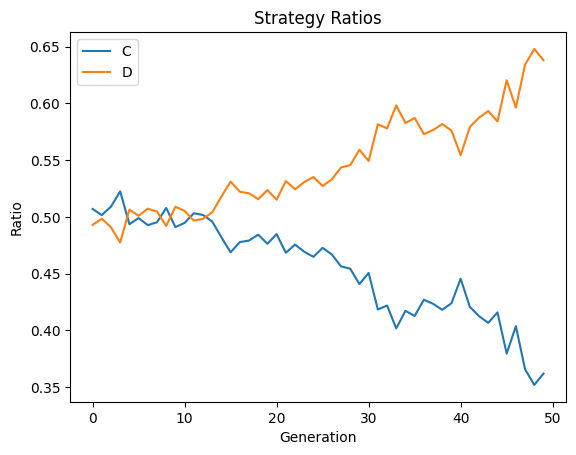

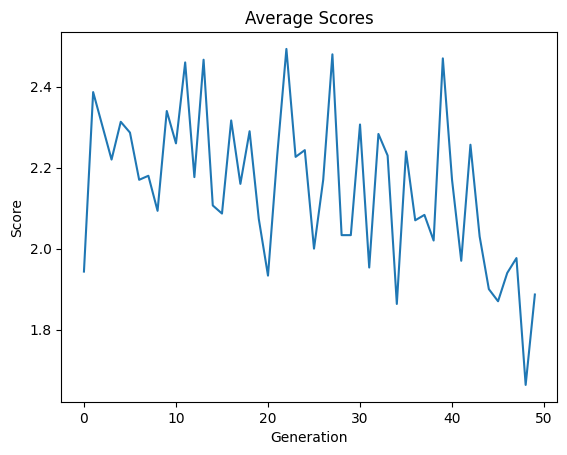

In [10]:
population = initialize_population()
c_ratios = []
average_scores = []

for generation in range(MAX_GENERATIONS):
    simulate_dilemma(population)
    c_ratios.append(sum(individual.c_ratio for individual in population) / POPULATION_SIZE)
    average_scores.append(sum(individual.score for individual in population) / POPULATION_SIZE)
    population = select(population)
    print('--- generation: {} ---'.format(generation + 1))
    print('cooperation ratio: {:.3f}'.format(c_ratios[-1]))
    print('average score: {:.3f}'.format(average_scores[-1]))
    population = crossover_and_mutate(population)

d_ratios = [1 - c_ratio for c_ratio in c_ratios]

plt.figure()
plt.plot(c_ratios, label='C')
plt.plot(d_ratios, label='D')
plt.title('Strategy Ratios')
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.legend()
plt.show()

plt.figure()
plt.plot(average_scores)
plt.title('Average Scores')
plt.xlabel('Generation')
plt.ylabel('Score')
plt.show()